# Deep Feature Based Image Segmentation

In this project, I have implemented an image segmentation algorithm. I pre-compute a deep image feature representation to play with using the famous self-supervised foundation model DINOv2.

In the digital world, an image can be represented as a tensor of shape $(H, W, 3)$, with H, W denoting the height and width of the image, 3 representing the color channel dimension. By applying deep neural networks, the image is essentially transformed into a feature tensor of shape $(h, w, d)$, where resolution is typically lower but feature dimension significantly higher, e.g. $d=256$.

The deep feature representation contains very rich semantic and geometric information, We will follow, to have a **feature visualization** through dimension reduction, and then design a segmentation algorithm based on **K-means clustering**. **The feature visualization section is independent of the K-means section.**

first, let's load the data.

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

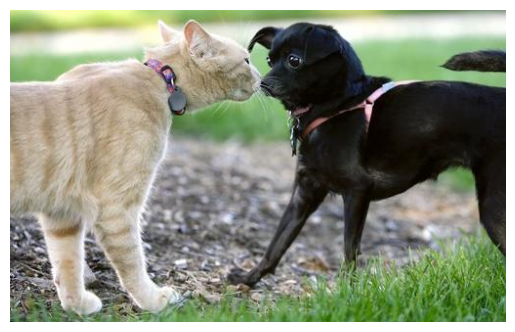

In [ ]:
# Load the image data
image_path = "./data_p/catdog.jpg"
image = mpimg.imread(image_path)
H, W, C = image.shape

# Visualize the image data
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# Load the deep feature
feature_path = "./data_p/catdog_features.npy"
image_features = np.load(feature_path)
h, w, d = image_features.shape

# Deep feature representation typically has lower resolution but significantly higher dimensionality, making visualization challenging.
print(f"image shape: {image.shape}, image feature shape: {image_features.shape}")

image shape: (320, 508, 3), image feature shape: (80, 127, 256)


To make our computation easier, we reshape the image features to be in the shape of $(h * w, d)$ such that the first dimension is the number of data points and the second dimension is the number of features.

We will refer to the resulting matrix as the data matrix $X$ with shape $(n, d)$, where $n = h * w$.

In [ ]:
X = image_features.reshape(-1, d)
print(f"data matrix X shape: {X.shape}")

data matrix X shape: (10160, 256)


## Feature Visualization

The dimension of image deep features are very high, we have to reduce the dimension to very low, e.g. 3, to be visualized.

Principal Component Analysis (PCA) is a technique for reducing the dimensionality of data while preserving as much variance as possible.

### PCA mathematical formulation

PCA solves the following optimization problem to maximize the variances after transformation:

$$
V = \arg \max_V \sum_{i=1}^{n} \| X V \|^2
$$

subject to the constraint:

$$
V^T V = I
$$

where:
- $ X $ is the mean-centered data matrix of shape $ (n \times d) $,
- $ V $ is the transformation matrix containing the top $ k $ eigenvectors of the covariance matrix,
- The constraint $ V^T V = I $ ensures that the principal components are orthonormal.


### Step 1: Standardizing the Data
Let $X$ be the data matrix of shape $n \times d$, where $n$ is the number of samples, and $d$ is the number of features. First, compute the mean of each feature:

$$
\bar{x}_j = \frac{1}{n} \sum_{i=1}^{n} x_{ij}
$$

where $x_{ij}$ is the value of the $j$-th feature for the $i$-th sample. The mean-centered data matrix is:

$$
X' = X - \mu
$$

where $\mu$ is the mean vector of shape $1 \times d$.

### Step 2: Compute the Covariance Matrix
The covariance matrix $C$ is given by:

$$
C = \frac{1}{n-1} X'^T X'
$$

where $C$ is an $d \times d$ symmetric matrix.

In [ ]:

def standardize_and_compute_covariance(X):
    """
    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    Returns:
    X_prime (n, d): The standarized data_matrix.
    C (d, d): The covariance matrix of the standardized data.
    """
    # Step 1: Standardize the data points (zero mean)
    X_prime = X - np.mean(X, axis=0)

    # Step 2: Compute the covariance matrix
    C = X_prime.T @ X_prime / (X.shape[0] - 1)

    # make use of the assert statement later if you want!
    n, d = X.shape
    assert C.shape == (d, d), f"Expected shape is {d, d} but got {C.shape}"

    return X_prime, C

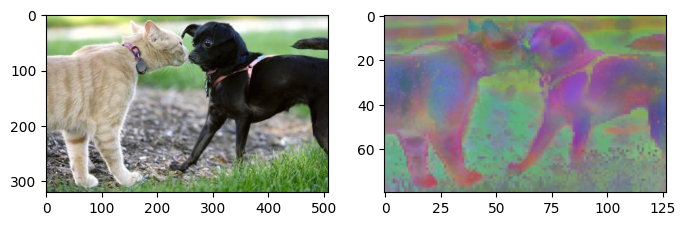

In [ ]:
## Test the implemented function here
X_prime, C = standardize_and_compute_covariance(X)

# Simply pick up and visualize the first three channels of the standardized data, which should be already decent to some extent
X_3 = (X_prime - X_prime.min()) / (X_prime.max() - X_prime.min())
X_3 = X_3 * 255
f, axarr = plt.subplots(1, 2, figsize=(8, 16))
axarr[0].imshow(image)
axarr[1].imshow(X_3[:,:3].reshape(h, w, 3).astype(np.uint8))

### Step 3: Compute Eigenvalues and Eigenvectors
We solve the eigenvalue problem:

$$
C v = \lambda v
$$

where:
- $\lambda$ (eigenvalue) represents the variance captured by the corresponding principal component.
- $v$ (eigenvector) represents the direction of the principal component.

The eigen decomposition problem can be effectively solved by using existing libraries.

### Step 4: Sort Eigenvalues and Eigenvectors
The eigenvalues $\lambda_1, \lambda_2, ..., \lambda_d$ are sorted in descending order:

$$
\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_d
$$

The corresponding eigenvectors are also sorted accordingly.

### Step 5: Select the Top Principal Components
To reduce the dimensionality to $k$ components ($k \leq d$), we select the first $k$ eigenvectors:

$$
V_k = [v_1, v_2, ..., v_k]
$$

where $V_k$ is an $d \times k$ matrix.

<span style="font-size:30px">Please implement the following function (10 pts)</span>

In [ ]:
def compute_principal_components(C, k):
    """
    Parameters:
    C (d, d): The covariance matrix comptuted from the data matrix.
    k (int): The number of principal components to retain.
    Returns:
    V_k (d, k): The principal compnents of the covariance matrix.
    """

    # Step 3: Compute eigenvalues and eigenvectors
    # Hint: use np.linalg.eigh
    eigenvalues, eigenvectors = np.linalg.eigh(C)

    # Step 4: Sort eigenvalues in descending order and sort eigenvectors accordingly
    # Hint: use np.argsort (which sorts in ascending order!!)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Select the top n_components eigenvectors
    V_k = eigenvectors[:, :k]

    return V_k

In [ ]:
## Test the implemented function here
V_k = compute_principal_components(C, 2)

### Step 6: Project Data onto the Principal Components
The transformed data is obtained as:

$$
X_{\text{reduced}} = X' V_k
$$

where $X_{\text{reduced}}$ is an $n \times k$ matrix representing the data in the reduced feature space.

<span style="font-size:30px">Please implement the following function (10 pts)</span>

In [ ]:
def projection(X_prime, V_k):
    """
    Parameters:
    X_prime (n, d): The standarized data_matrix.
    V_k (d, k): The principal compnents of the covariance matrix.
    Returns:
    X_reduced (n, k): The transformed data with reduced dimensions.
    """

    # Step 6: Project the data onto the principal components
    X_reduced = X_prime @ V_k

    return X_reduced

In [ ]:
## Test the implemented function here
X_reduced = projection(X_prime, V_k)

Now, let's assemble all the small functions together:

In [ ]:
def pca(X, k):
    """
    Perform Principal Component Analysis (PCA) on data matrix X.

    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    k (int): The number of principal components to retain.

    Returns:
    X_reduced (n, k): The transformed data with reduced dimensions.
    """

    X_prime, C = standardize_and_compute_covariance(X)
    V_k = compute_principal_components(C, k)
    X_reduced = projection(X_prime, V_k)

    return X_reduced

In [ ]:
# Set k = 3 to be used as color channels
k = 3

# Perform PCA on the image features
pca_features = pca(X, k)
print(f"pca_features shape: {pca_features.shape}")

pca_features shape: (10160, 3)


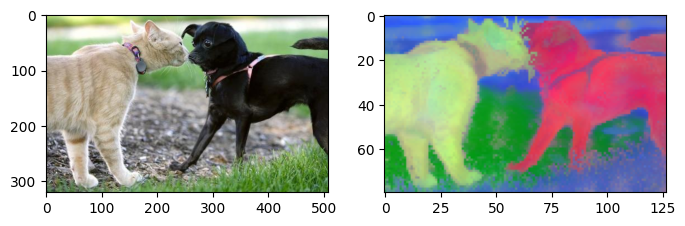

In [ ]:
# Transform the PCA features to color channels
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

# Visualize the original image and the PCA features
f, axarr = plt.subplots(1, 2, figsize=(8, 16))
axarr[0].imshow(image)
axarr[1].imshow(pca_features.reshape(h, w, 3).astype(np.uint8))

## K-Means Segmentation

The K-means algorithm is a clustering method used to partition a set of data points into $ K $ clusters. The goal is to minimize the variance within each cluster and assign each data point to the nearest cluster.

The algorithm follows these steps:

1. **Initialize Centroids**: Randomly select $ K $ data points from the dataset to serve as the initial centroids.
2. **Assign Clusters**: For each data point, calculate the distance to each centroid and assign the data point to the nearest centroid (i.e., the cluster).
3. **Update Centroids**: After all points are assigned, update the centroids by calculating the mean of the points in each cluster.
4. **Repeat**: Repeat steps 2 and 3 until the centroids no longer change significantly (or the maximum number of iterations is reached).

### Notations:
- Let $ X = \{x_1, x_2, \dots, x_n\} $ be the dataset with $ n $ points in a $ n $-dimensional space.
- Let $ C = \{C_1, C_2, \dots, C_K\} $ be the $ K $ clusters.
- Let $ \mu_k $ be the centroid of the $ k $-th cluster.
- Let $ y_i $ be the label assigned to data point $ x_i $, where $ y_i \in \{1, 2, \dots, K\} $ represents the cluster index.

### Steps of K-Means:

1. **Initialize centroids randomly**: Select $ K $ points randomly from the dataset to serve as initial centroids. The centroids will be updated iteratively.



<span style="font-size:30px">Please implement the following function (10 pts)</span>

In [ ]:
def initialize_centroids(X, K):
    """
    Randomly initialize K centroids from the data matrix X.

    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    K (int): The number of clusters.

    Returns:
    centroids (K, d): The initialized centroids.
    """

    ## hint: Do not initialize the centriods with the same values.
    n, d = X.shape
    centroids = X[np.random.choice(n, K, replace=False)]

    return centroids

In [ ]:
## Test the implemented function here

# Set the number of clusters
K = 2

# Initialze centroids for K-means
init_centroids = initialize_centroids(X, K)

2. **Assign each data point to the nearest centroid**: For each point $ x_i $, compute the Euclidean distance to each centroid $ \mu_k $ and assign the point to the cluster whose centroid is closest.
   $$
   y_i = \arg \min_k \left( \|x_i - \mu_k\|_2 \right)
   $$
   where $ \|x_i - \mu_k\|_2 $ is the Euclidean distance between $ x_i $ and $ \mu_k $.

<span style="font-size:30px">Please implement the following function (10 pts)</span>

In [ ]:
def assign_to_centroids(X, centroids):
    """
    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    centroids (K, d): The centroids of the clusters.

    Returns:
    labels (n): The index of the closest centroid for each sample.
    """

    # Step 1: Compute the distance between each point and each centroid
    ##Hint, distances should have shape (n, K)
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    # Step 2: Assign each point to the closest centroid
    labels = np.argmin(distances, axis=1)

    return labels

In [ ]:
## Test the implemented function here
labels = assign_to_centroids(X, init_centroids)

3. **Update the centroids**: Once all points have been assigned to clusters, update the centroids by calculating the mean of all points in each cluster:
   $$
   \mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i
   $$
   where $ C_k $ is the set of points assigned to cluster $ k $.

<span style="font-size:30px">Please implement the following function (10 pts)</span>

In [ ]:
def update_centroids(X, labels, K):
    """
    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    labels (n): The index of the closest centroid for each sample.
    K (int): The number of clusters.

    Returns:
    centroids (K, d): The updated centroids of the clusters.
    """

    # Step 3: Compute the new centroids
    centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])

    return centroids

In [ ]:
## Test the implemented function here
updated_centroids = update_centroids(X, labels, K)

K-means function: Repeat steps 2 and 3 until convergence, i.e., when the centroids no longer change significantly.

In [ ]:
def kmeans(X, K, init, max_iters=100, tolerance=1e-4):

    """
    Parameters:
    X (n, d): The input data matrix where rows represent samples and columns represent features.
    K (int): The number of clusters.
    init (K, d): Initial centroids for the clusters.

    Returns:
    centroids (K, d): The updated centroids of the clusters.
    labels (n): The index of the closest centroid for each sample.
    """

    # initial centroids
    centroids = init
    for i in range(max_iters):
        # Step 2: Assign each point to the nearest centroid
        labels = assign_to_centroids(X, centroids)

        # Step 3: Update centroids
        new_centroids = update_centroids(X, labels, K)

        # Check for convergence (if centroids do not change significantly)
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break
        centroids = new_centroids

    return centroids, labels

In [ ]:
def visualize_segmentation(image, labels, K):
    # Visualize the original image and the segmentation result
    cluster_colors = np.array([plt.cm.get_cmap('tab10')(i)[:3] for i in range(K)])
    clustered_image = cluster_colors[labels].reshape(h, w, 3)  # Assign colors to pixel
    f, axarr = plt.subplots(1, 2, figsize=(8, 16))
    axarr[0].imshow(image)
    axarr[1].imshow(clustered_image)

/tmp/ipykernel_3647/869033739.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = np.array([plt.cm.get_cmap('tab10')(i)[:3] for i in range(K)])


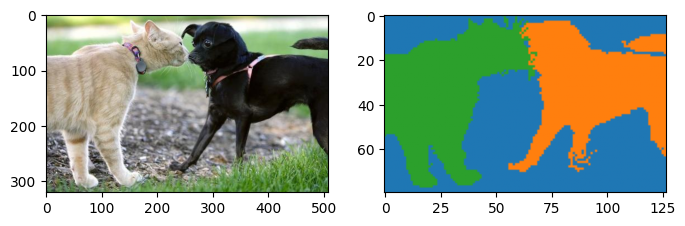

In [ ]:
# Set the number of clusters, you can change this value to see different segmentation results
K = 3

# Perform K-means clustering
init_centroids = initialize_centroids(X, K)
centroids, labels = kmeans(X, init=init_centroids, K=K)

# Visualize the segmentation result
visualize_segmentation(image, labels, K)